# Wikipedia Vectors - Getting Started

In this project, we learned embeddings for Wikipedia articles and [Wikidata](https://www.wikidata.org/wiki/Wikidata:Main_Page) items by applying [Word2vec](https://en.wikipedia.org/wiki/Word2vec) models to a corpus of reading sessions.

Although Word2vec models were developed to learn word embeddings from a corpus of sentences, they can be applied to any kind of sequential data. The learned embeddings have the property that items with similar neighbors in the training corpus have similar representations (as measured by the [cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity), for example). Consequently, applying Wor2vec to reading sessions results in article embeddings, where articles that tend to be read in close succession have similar representations. Since people usually generate sequences of semantically related articles while reading, these embeddings also capture semantic similarity between articles.

There have been several approaches to learning vector representations of Wikipedia articles that capture semantic similarity by using the article text or the links between articles. An advantage of training Word2vec models on reading sessions, is that they learn from the actions of millions of humans who are using a diverse array of signals, including the article text, links, third-party search engines, and their existing domain knowledge, to determine what to read next in order to learn about a topic.

An additional feature of not relying on text or links, is that we can learn representations for [Wikidata Items](https://www.wikidata.org/wiki/Help:Items) by simply mapping article titles within each session to Wikidata items using [Wikidata sitelinks](https://www.wikidata.org/wiki/Help:Sitelinks). As a result, these Wikidata vectors are jointly trained over reading sessions for all Wikipedia language editions, allowing the model to learn from people across the globe. This approach also overcomes data sparsity issues for smaller Wikipedias, since the representations for articles in smaller Wikipedias are shared across many other potentially larger ones. Finally, instead of needing to generate a separate embedding for each Wikipedia in each language, we have a single model that gives a vector representation for any article in any language, provided the article has been mapped to a Wikidata item.

### A Simple Embedding Class

The `WikiEmbedding` class takes care of loading the vector data into a matrix and exposes a method for finding the nearest neighbors of an article in the embedding.

In [1]:
import numpy as np
from sklearn.preprocessing import normalize
import requests
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload
%autoreload 2


class WikiEmbedding:

    def __init__(self, fname):
        
        self.w2idx = {}
        self.idx2w = []
    
        with open(fname, 'rb') as f:
            
            m, n = next(f).decode('utf8').strip().split(' ')
            self.E = np.zeros((int(m), int(n)))

            for i, l in enumerate(f):
                l = l.decode('utf8').strip().split(' ')
                w = l[0]
                self.E[i] = np.array(l[1:])
                self.w2idx[w] = i
                self.idx2w.append(w)
                
        self.E = normalize(self.E)
        self.idx2w = np.array(self.idx2w)

    def most_similar(self, w, n=10, min_similarity=0.5):
        """
        Find the top-N most similar words to w, based on cosine similarity.
        As a speed optimization, only consider neighbors with a similarity
        above min_similarity
        """
        
        if type(w) is str:
            w = self.E[self.w2idx[w]]

        scores = self.E.dot(w)
        # only consider neighbors above threshold
        min_idxs = np.where(scores > min_similarity)
        ranking = np.argsort(-scores[min_idxs])[1:(n+1)]
        nn_ws = self.idx2w[min_idxs][ranking]
        nn_scores = scores[min_idxs][ranking]
        return list(zip(list(nn_ws), list(nn_scores)))
    

### Exploring Nearest Neighbors

Here we load an embedding over English Wikipedia articles trained on reading sessions in enwiki for the first week of March 2016 (Note: we will get to using Wikidata embeddings in a bit). We then show the nearest neighbors for some sample articles.

In [7]:
en_embedding = WikiEmbedding('../data/2016-03-01_2016-03-07/2016-03-01_2016-03-07_en_200')

In [11]:
en_embedding.most_similar('Word2vec')

[('Word_embedding', 0.95622320591391496),
 ('Gensim', 0.9269277744544846),
 ('Brown_clustering', 0.90669111256072077),
 ('Bag-of-words_model', 0.8997812984904453),
 ('Distributional_semantics', 0.89210129481761236),
 ('Bag-of-words_model_in_computer_vision', 0.89153302212057661),
 ('Topic_model', 0.89111001451403138),
 ('Feature_learning', 0.88864836681622683),
 ('Vector_space_model', 0.88702724731990568),
 ('Document-term_matrix', 0.88491820738885474)]

In [12]:
en_embedding.most_similar('Wikipedia')

[('Wiki', 0.83135166035258534),
 ('English_Wikipedia', 0.80031730995900063),
 ('Wikimedia_Foundation', 0.72032968647518936),
 ('Larry_Sanger', 0.6898701159733629),
 ('Nupedia', 0.68647996980941084),
 ('History_of_Wikipedia', 0.63363057247932586),
 ('Encyclopedia', 0.61845099080085975),
 ('Jimmy_Wales', 0.61750657289550304),
 ('Wikipedia_community', 0.58988242628270737),
 ('List_of_wikis', 0.58899013182893245)]

### Visualizing the Embedding using TSNE


The [t-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding) algorithm tries to take a collection of high dimensional vectors and find lower dimensional representations such that the relative distances between points stay preserved as well as possible. This allows us to visualize a part of the embedding in 2D. In the plot below you see the 2D t-SNE projection for the 20 most popular articles in the training data. (Note: The code for getting a readable scatter plot is a bit hairy, so the code has been factored out to a helper file)

In [13]:
from getting_started_helpers import get_tsne, plot_tsne

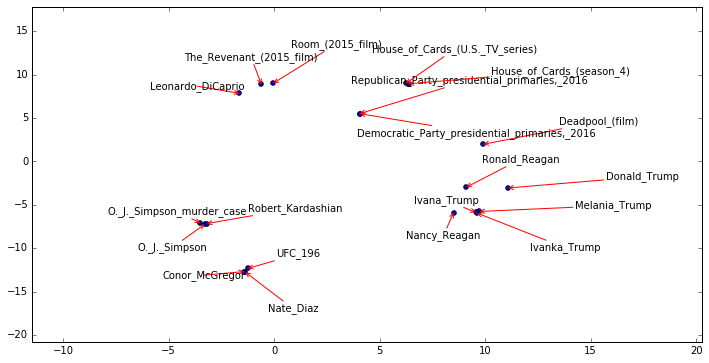

In [24]:
tsne_en_embedding = get_tsne(en_embedding, pca_dim = 10, n_words=5000)
plot_tsne(en_embedding, tsne_en_embedding, n = 20)

When looking at a single week of data, the most popular articles tend to be about things trending in the media. We can see that articles about similar topics and events cluster together.

### Working with Wikidata Vectors

One difficulty with working with the Wikidata embedding is that item ids are hard to interpret. We can, however, use the Wikidata API to map back and forth between Wikipedia articles and Wikidata ids. Below are some helper funtions for doing the mapping.

In [20]:
def items_to_titles(items, lang):
    """
    Input: a list of Wikidata item ids
    Output: a dictionary mapping from ids to title in lang
    
    Note: items without an articlce in lang are not included in the output
    """
    lang += 'wiki'
    payload = {'action': 'wbgetentities',
               'props': 'sitelinks/urls',
               'format': 'json',
               'ids': '|'.join(items),               
              }
    r = requests.get('https://www.wikidata.org/w/api.php', params=payload).json()
    
    return parse_wikidata_sitelinks(r, lang, True)
    
    
def titles_to_items(titles, lang):
    """
    Input: a list of article titles in lang
    Output: a dictionary mapping from titles in lang to Wikidata ids
    
    Note: articles in lang without a Wikidata id are not included in the output

    """
    lang += 'wiki'
    payload = {'action': 'wbgetentities',
               'props': 'sitelinks/urls',
               'format': 'json',
               'sites': lang,
               'titles': '|'.join(titles),
              }
    r = requests.get('https://www.wikidata.org/w/api.php', params=payload).json()
    
    return parse_wikidata_sitelinks(r, lang, False)


def parse_wikidata_sitelinks(response, lang, item_to_title):
    """
    Helper function for parsing sitelinks from Wikidata Api
    """
    d = {}
    if 'entities' not in response:
        print ('No entities in reponse')
        return d

    for item, v in response['entities'].items():
        if 'sitelinks' in v:
            if lang in v['sitelinks']:
                title = v['sitelinks'][lang]['title'].replace(' ', '_')
                if item_to_title:
                    d[item] = title
                else:
                    d[title] = item
    return d

Given these helper functions, we can now look for nearest neighbors for a Wikipedia article in any language by first mapping the article to its Wikidata item, then finding the nearest neighbors in the Wikidata embedding and finally mapping the Wikidata items back to article names.

In [21]:
def most_similar(embedding, title, lang, n=10, min_similarity=0.7):
    item = titles_to_items([title,], lang)[title]
    nn = embedding.most_similar(item, n=n, min_similarity=min_similarity)
    nn_items = [x[0] for x in nn]
    nn_items_to_titles = items_to_titles(nn_items, lang)
    return [(nn_items_to_titles[x[0]], x[1]) for x in nn if x[0] in nn_items_to_titles]    

Lets try it out! First we load the wikidata embedding.

In [17]:
wikidata_embedding = WikiEmbedding('../data/2016-03-01_2016-03-07/2016-03-01_2016-03-07_wikidata_200')

Then we can query nearest neighbors for 'Q1', the 'Universe' Wikidata item.

In [18]:
wikidata_embedding.most_similar('Q1')

[('Q229206', 0.84477422002858837),
 ('Q318', 0.81135711307867753),
 ('Q323', 0.80632248705977405),
 ('Q1059081', 0.74788564287585446),
 ('Q4169', 0.74763828248109099),
 ('Q16652009', 0.74135312707844747),
 ('Q221392', 0.74040813066583788),
 ('Q321', 0.73970201130507318),
 ('Q5646104', 0.72849855030646837),
 ('Q4113683', 0.72136321375851276)]

Or we can get query the Wikidata embedding for the nearest neighbors for enwiki 'Universe' article.

In [22]:
most_similar(wikidata_embedding, 'Universe', 'en')

[('Universe_(disambiguation)', 0.84477422002858837),
 ('Galaxy', 0.81135711307867753),
 ('Big_Bang', 0.80632248705977405),
 ('Cosmos', 0.74788564287585446),
 ('Outer_space', 0.74763828248109099),
 ('Observable_universe', 0.74040813066583788),
 ('Milky_Way', 0.73970201130507318)]

As a comparison, here are the nearest neighbors for 'Universe' in the enwiki embedding, which was only trained on enwiki reading sessions. The top neighbors are pretty different.

In [23]:
en_embedding.most_similar('Universe')

[('Galaxy', 0.75095664705345322),
 ('Big_Bang', 0.73286463650342037),
 ('Observable_universe', 0.7147260573035995),
 ('Cosmology', 0.70745898607895163),
 ('Black_hole', 0.70578432763442023),
 ('Space', 0.70260179366002262),
 ('Dark_energy', 0.69894009721233485),
 ('Cosmos', 0.69662786946118804),
 ('Age_of_the_universe', 0.67630310625186396),
 ('History_of_the_Big_Bang_theory', 0.67207617659185392)]

### Application Ideas

Here are some ideas for how to use these embeddings to improve Wikipedia.

#### Translation Recommendations

We recently created a [tool](http://recommend.wmflabs.org/#Recommend) for recommending articles for translation between Wikipedias. Users choose a source language to translate from and a target language to translate to. Then they choose a seed article in the source language that represents their interests. We can find articles in the source language missing in the target language using Wikidata sitelinks, and then rank the missing articles according to the similarity between their vectors and the seed vector. 

#### Reading Recommendations
The Reading Team at WMF recently introduced a "Related Pages" feature that gives readers 3 recommendations for further reading. The current recommendations are generated by the [More Like This Query](https://www.elastic.co/guide/en/elasticsearch/reference/current/query-dsl-mlt-query.html) feature in Elastic Search.

Instead, we could generate recommendations for further reading by looking up the nearest neighbors of the current article the reader is on in an embedding. The beauty of this approach is that the nearest neighbors are by definition articles that tend to be read together. Furthermore, the Wikidata embedding would allow us to use a single model to generate recommendations across all languages!

#### Link Recommendations
If articles are frequently read within the same session, you might be able to make Wikipedia easier to navigate if you were to create a link between them. For a given article you could generate recommendations for links to add by finding the nearest neighbors that are not already linked and adding a link if the original article has a suitable anchor text. Again, the Wikidata embedding would allow you to build a model for all languages.